# Evolver Loop 1 Analysis

Analyzing the baseline experiment results and data patterns to inform next steps.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
train_df = pd.read_csv('/home/data/train.csv')
test_df = pd.read_csv('/home/data/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTarget distribution:")
print(train_df['Survived'].value_counts().sort_index())
print(f"Survival rate: {train_df['Survived'].mean():.3f}")

Training data shape: (891, 12)
Test data shape: (418, 11)

Target distribution:
Survived
0    549
1    342
Name: count, dtype: int64
Survival rate: 0.384


## Analyze Data Leakage Issue

The evaluator flagged that we combined train and test for preprocessing. Let me quantify the impact.

In [2]:
# Separate target and features
X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']
X_test = test_df.drop(['PassengerId'], axis=1)

print("=== TRAIN SET STATISTICS ===")
print(f"Age - median: {X['Age'].median():.2f}, mean: {X['Age'].mean():.2f}")
print(f"Fare - median: {X['Fare'].median():.2f}, mean: {X['Fare'].mean():.2f}")
print(f"Embarked - mode: {X['Embarked'].mode()[0]}")
print(f"Embarked distribution:\n{X['Embarked'].value_counts()}")

print("\n=== TEST SET STATISTICS ===")
print(f"Age - median: {X_test['Age'].median():.2f}, mean: {X_test['Age'].mean():.2f}")
print(f"Fare - median: {X_test['Fare'].median():.2f}, mean: {X_test['Fare'].mean():.2f}")
print(f"Embarked - mode: {X_test['Embarked'].mode()[0]}")
print(f"Embarked distribution:\n{X_test['Embarked'].value_counts()}")

print("\n=== COMBINED STATISTICS (CURRENT LEAKY APPROACH) ===")
combined = pd.concat([X, X_test], axis=0)
print(f"Age - median: {combined['Age'].median():.2f}, mean: {combined['Age'].mean():.2f}")
print(f"Fare - median: {combined['Fare'].median():.2f}, mean: {combined['Fare'].mean():.2f}")
print(f"Embarked - mode: {combined['Embarked'].mode()[0]}")

# Calculate differences
train_age_median = X['Age'].median()
test_age_median = X_test['Age'].median()
combined_age_median = combined['Age'].median()

print(f"\n=== DIFFERENCES ===")
print(f"Age median - Train: {train_age_median:.2f}, Test: {test_age_median:.2f}, Combined: {combined_age_median:.2f}")
print(f"Age: Train vs Combined difference: {abs(train_age_median - combined_age_median):.2f}")
print(f"Age: Test vs Combined difference: {abs(test_age_median - combined_age_median):.2f}")

=== TRAIN SET STATISTICS ===
Age - median: 28.00, mean: 29.70
Fare - median: 14.45, mean: 32.20
Embarked - mode: S
Embarked distribution:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

=== TEST SET STATISTICS ===
Age - median: 27.00, mean: 30.27
Fare - median: 14.45, mean: 35.63
Embarked - mode: S
Embarked distribution:
Embarked
S    270
C    102
Q     46
Name: count, dtype: int64

=== COMBINED STATISTICS (CURRENT LEAKY APPROACH) ===
Age - median: 28.00, mean: 29.88
Fare - median: 14.45, mean: 33.30
Embarked - mode: S

=== DIFFERENCES ===
Age median - Train: 28.00, Test: 27.00, Combined: 28.00
Age: Train vs Combined difference: 0.00
Age: Test vs Combined difference: 1.00


## Analyze Feature Patterns

Let's examine what features are most predictive to guide our feature engineering.

In [4]:
# Create a proper non-leaky preprocessing pipeline for analysis
from sklearn.impute import SimpleImputer

# Make a copy for proper preprocessing
X_clean = X.copy()
X_test_clean = X_test.copy()

# Impute using TRAIN data only
age_imputer = SimpleImputer(strategy='median')
age_imputer.fit(X_clean[['Age']])
X_clean['Age'] = age_imputer.transform(X_clean[['Age']]).flatten()
X_test_clean['Age'] = age_imputer.transform(X_test_clean[['Age']]).flatten()

fare_imputer = SimpleImputer(strategy='median')
fare_imputer.fit(X_clean[['Fare']])
X_clean['Fare'] = fare_imputer.transform(X_clean[['Fare']]).flatten()
X_test_clean['Fare'] = fare_imputer.transform(X_test_clean[['Fare']]).flatten()

embarked_imputer = SimpleImputer(strategy='most_frequent')
embarked_imputer.fit(X_clean[['Embarked']])
X_clean['Embarked'] = embarked_imputer.transform(X_clean[['Embarked']]).flatten()
X_test_clean['Embarked'] = embarked_imputer.transform(X_test_clean[['Embarked']]).flatten()

# Extract titles
X_clean['Title'] = X_clean['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
X_test_clean['Title'] = X_test_clean['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)

# Map titles
title_mapping = {
    'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
    'Dr': 'Other', 'Rev': 'Other', 'Col': 'Other', 'Major': 'Other',
    'Mlle': 'Miss', 'Countess': 'Other', 'Ms': 'Miss', 'Lady': 'Other',
    'Jonkheer': 'Other', 'Don': 'Other', 'Dona': 'Other', 'Mme': 'Mrs',
    'Capt': 'Other', 'Sir': 'Other'
}
X_clean['Title'] = X_clean['Title'].map(title_mapping)
X_test_clean['Title'] = X_test_clean['Title'].map(title_mapping)

# Fill any missing titles
X_clean['Title'].fillna('Other', inplace=True)
X_test_clean['Title'].fillna('Other', inplace=True)

# Create family size
X_clean['FamilySize'] = X_clean['SibSp'] + X_clean['Parch'] + 1
X_test_clean['FamilySize'] = X_test_clean['SibSp'] + X_test_clean['Parch'] + 1

# Create cabin indicator
X_clean['HasCabin'] = (X_clean['Cabin'].notna()).astype(int)
X_test_clean['HasCabin'] = (X_test_clean['Cabin'].notna()).astype(int)

# Drop high cardinality features
X_clean.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X_test_clean.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

print("Clean data shapes:", X_clean.shape, X_test_clean.shape)

# Analyze survival rates by feature
print("\n=== SURVIVAL RATES BY FEATURE ===")

# Sex
print("\nSex:")
sex_survival = train_df.groupby('Sex')['Survived'].agg(['count', 'sum', 'mean'])
sex_survival.columns = ['Total', 'Survived', 'SurvivalRate']
print(sex_survival)

# Pclass
print("\nPclass:")
pclass_survival = train_df.groupby('Pclass')['Survived'].agg(['count', 'sum', 'mean'])
pclass_survival.columns = ['Total', 'Survived', 'SurvivalRate']
print(pclass_survival)

# Title
print("\nTitle:")
title_survival = pd.DataFrame({'Title': X_clean['Title'], 'Survived': y})
title_stats = title_survival.groupby('Title')['Survived'].agg(['count', 'sum', 'mean'])
title_stats.columns = ['Total', 'Survived', 'SurvivalRate']
print(title_stats)

# HasCabin
print("\nHasCabin:")
cabin_survival = pd.DataFrame({'HasCabin': X_clean['HasCabin'], 'Survived': y})
cabin_stats = cabin_survival.groupby('HasCabin')['Survived'].agg(['count', 'sum', 'mean'])
cabin_stats.columns = ['Total', 'Survived', 'SurvivalRate']
print(cabin_stats)

Clean data shapes: (891, 10) (418, 10)

=== SURVIVAL RATES BY FEATURE ===

Sex:
        Total  Survived  SurvivalRate
Sex                                  
female    314       233      0.742038
male      577       109      0.188908

Pclass:
        Total  Survived  SurvivalRate
Pclass                               
1         216       136      0.629630
2         184        87      0.472826
3         491       119      0.242363

Title:
        Total  Survived  SurvivalRate
Title                                
Master     40        23      0.575000
Miss      185       130      0.702703
Mr        517        81      0.156673
Mrs       126       100      0.793651
Other      23         8      0.347826

HasCabin:
          Total  Survived  SurvivalRate
HasCabin                               
0           687       206      0.299854
1           204       136      0.666667


## Analyze Cabin Information

The evaluator mentioned we might be losing information by only using a binary indicator. Let me analyze the cabin letters.

In [5]:
# Analyze cabin letters
print("=== CABIN ANALYSIS ===")

# Extract deck letters from train and test
train_cabins = train_df['Cabin'].dropna()
test_cabins = test_df['Cabin'].dropna()

print(f"Train cabins (non-null): {len(train_cabins)} out of {len(train_df)} ({len(train_cabins)/len(train_df)*100:.1f}%)")
print(f"Test cabins (non-null): {len(test_cabins)} out of {len(test_df)} ({len(test_cabins)/len(test_df)*100:.1f}%)")

# Extract deck letters
train_decks = train_cabins.str[0]
test_decks = test_cabins.str[0]

print("\nTrain deck distribution:")
print(train_decks.value_counts())

print("\nTest deck distribution:")
print(test_decks.value_counts())

# Analyze survival by deck (for training data)
print("\n=== SURVIVAL RATES BY DECK ===")
train_with_cabin = train_df[train_df['Cabin'].notna()].copy()
train_with_cabin['Deck'] = train_with_cabin['Cabin'].str[0]

deck_survival = train_with_cabin.groupby('Deck')['Survived'].agg(['count', 'sum', 'mean'])
deck_survival.columns = ['Total', 'Survived', 'SurvivalRate']
print(deck_survival)

# Statistical significance
from scipy.stats import chi2_contingency

# Create contingency table for deck vs survival
deck_crosstab = pd.crosstab(train_with_cabin['Deck'], train_with_cabin['Survived'])
print(f"\nContingency table:\n{deck_crosstab}")

chi2, p_value, dof, expected = chi2_contingency(deck_crosstab)
print(f"\nChi-square test: chi2={chi2:.3f}, p-value={p_value:.3f}")
print(f"Deck has significant association with survival: {p_value < 0.05}")

=== CABIN ANALYSIS ===
Train cabins (non-null): 204 out of 891 (22.9%)
Test cabins (non-null): 91 out of 418 (21.8%)

Train deck distribution:
Cabin
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

Test deck distribution:
Cabin
C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: count, dtype: int64

=== SURVIVAL RATES BY DECK ===
      Total  Survived  SurvivalRate
Deck                               
A        15         7      0.466667
B        47        35      0.744681
C        59        35      0.593220
D        33        25      0.757576
E        32        24      0.750000
F        13         8      0.615385
G         4         2      0.500000
T         1         0      0.000000

Contingency table:
Survived   0   1
Deck            
A          8   7
B         12  35
C         24  35
D          8  25
E          8  24
F          5   8
G          2   2
T          1   0

Chi-square test: chi2=10.301, p-value=0.172
Deck has significant 

## Model Feature Importance

Train a model to see which features are most important.

=== FEATURE IMPORTANCE ===
      Feature  Importance
1         Sex    0.461740
5        Fare    0.144860
0      Pclass    0.117631
2         Age    0.096068
8  FamilySize    0.060587
7       Title    0.055475
9    HasCabin    0.041645
6    Embarked    0.014018
3       SibSp    0.007780
4       Parch    0.000197


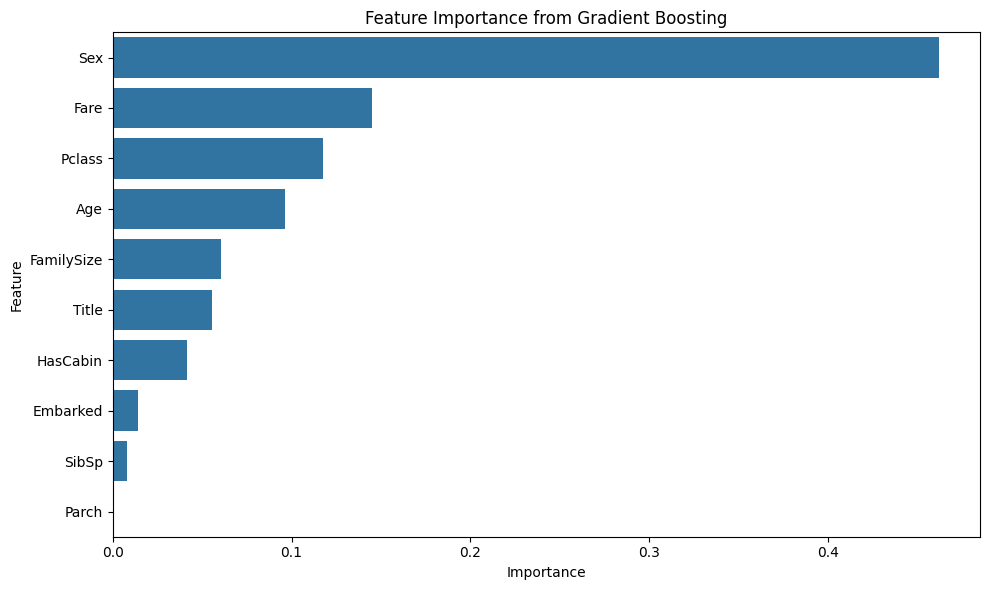


=== CLEAN CV SCORE (no leakage) ===
CV scores: [0.8715083798882681, 0.8595505617977528, 0.8146067415730337, 0.8258426966292135, 0.848314606741573]
Mean: 0.8440 ± 0.0210
Original leaky CV: 0.8417 ± 0.0213
Difference: 0.0023


In [6]:
# Encode categorical variables properly (non-leaky)
from sklearn.preprocessing import LabelEncoder

X_model = X_clean.copy()

categorical_cols = ['Sex', 'Embarked', 'Title', 'Pclass']
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_model[col] = le.fit_transform(X_model[col])
    encoders[col] = le

# Train a model to get feature importance
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_model, y)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_model.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=== FEATURE IMPORTANCE ===")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance from Gradient Boosting')
plt.tight_layout()
plt.show()

# Cross-validation score with clean data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_clean = []

for train_idx, val_idx in skf.split(X_model, y):
    X_train, X_val = X_model.iloc[train_idx], X_model.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model_fold = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model_fold.fit(X_train, y_train)
    
    y_pred = model_fold.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    cv_scores_clean.append(score)

print(f"\n=== CLEAN CV SCORE (no leakage) ===")
print(f"CV scores: {cv_scores_clean}")
print(f"Mean: {np.mean(cv_scores_clean):.4f} ± {np.std(cv_scores_clean):.4f}")
print(f"Original leaky CV: 0.8417 ± 0.0213")
print(f"Difference: {np.mean(cv_scores_clean) - 0.8417:.4f}")